function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=54beef2ae08a7441b945cb5042974d86812ffe612ecc82cfe34c0e2f70b9c75a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b3'

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt 
import numpy as np
from torchvision.transforms.functional import crop

image_size = EfficientNet.get_image_size(model_name)
batch_size = 32

In [5]:
image_size

300

In [6]:
!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

/bin/bash: conda: command not found
cuda


원래 이미지 size : 492. 654

In [7]:
def crop244(image):
    return crop(image, 200, 0, 292, 654)

In [10]:
compe1_train = datasets.ImageFolder(
    '/content/drive/Shareddrives/현대제조공정/data/Competition_No1/datasets/train_rereresampled',
    transforms.Compose([
#         transforms.RandomResizedCrop(image_size),
#         transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Lambda(crop244),
         transforms.Resize((image_size,image_size)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #normalize,
    ]))

compe1_validation = datasets.ImageFolder(
    '/content/drive/Shareddrives/현대제조공정/data/Competition_No1/datasets/validation_resampled',
    transforms.Compose([
#         transforms.RandomResizedCrop(image_size),
#         transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Lambda(crop244),
         transforms.Resize((image_size,image_size)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #normalize,
    ]))


In [ ]:
#train_size = int(0.8 * len(compe1_dataset))
#test_size = len(compe1_dataset) - train_size

In [ ]:
#train_set, val_set = torch.utils.data.random_split(compe1_dataset, [train_size, test_size])

In [8]:
dataloaders={}

In [11]:
dataloaders['train'] = torch.utils.data.DataLoader(compe1_train, batch_size=batch_size, shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(compe1_validation, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 300, 300])
Labels batch shape: torch.Size([32])


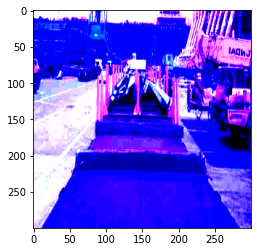

Label: 1


In [12]:
train_features, train_labels = next(iter(dataloaders['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [13]:
model = EfficientNet.from_pretrained(model_name, num_classes=2)
#model =  EfficientNet.from_pretrained(model_name, weights_path = "/content/drive/Shareddrives/현대제조공정/JIO/{}.pt".format(model_save_name), num_classes = 2)

for n, p in model.named_parameters():
    if '_fc' not in n:
        p.requires_grad = False
    if '_blocks.22' in n :
        if '_bn' not in n:
            p.requires_grad = True
    if '_conv_head.weight' in n:
        p.requires_grad = True

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [16]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
"""def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    model_save_name = model_name+ "_" + str(trial_num) + ".pt"
    path = "/content/drive/Shareddrives/현대제조공정/JIO/{}".format(model_save_name)
    torch.save(model.state_dict(),path)
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc
"""

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                torch.save(model.state_dict(), '/content/drive/Shareddrives/현대제조공정/JIO/president_model_%d_epoch.pt' %(best_idx))
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)


In [ ]:
import time
import copy
from tqdm import tqdm

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   42276 KB |   42276 KB |   42276 KB |       0 B  |\n|       from large pool |   25180 KB |   25180 KB |   25180 KB |       0 B  |\n|       from small pool |   17095 KB |   17095 KB |   17095 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |   42276 KB |   42276 KB |   42276 KB |       0 B  |\n|       from large pool |   25180 KB |   25180 KB |

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,  num_epochs=50)
model_save_name = 'b3_epoch50.pt'

path = "/content/drive/Shareddrives/현대제조공정/JIO/{}".format(model_save_name)
torch.save(model.state_dict(),path)

Epoch 0/49
----------


In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
"""model_save_name = 'classifier.pt'

path = "/content/drive/Shareddrives/현대제조공정/JIO/{}".format(model_save_name)
torch.save(model.state_dict(),path)
"""

# grad_cam

In [ ]:
model =  EfficientNet.from_pretrained(model_name, weights_path = "/content/drive/Shareddrives/현대제조공정/JIO/president_model_26_epoch.pt", num_classes = 2)

Loaded pretrained weights for efficientnet-b2


In [ ]:
!git clone "https://github.com/tanjimin/grad-cam-pytorch-light"

Cloning into 'grad-cam-pytorch-light'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (33/33), done.


In [ ]:
import cv2
import torch
import numpy as np

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image

def grad_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)

In [ ]:
!pip install wheel
!pip install twine
from PIL import Image

     |████████████████████████████████| 138 kB 15.3 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 3.6 MB 82.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:

def printcam(name, boxer_label = 1) :
    # Preprocess image
    img = Image.open(name)
    tfms = transforms.Compose([
                               transforms.ToTensor(),
        #transforms.Lambda(lambda x : crop244(x)),
        transforms.Resize((image_size,image_size))])
    #                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
    img = tfms(img).unsqueeze(0)    
    plt.figure(figsize = (13,8))
    model.eval()
    model.cpu()
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Lambda(lambda x : crop244(x)),
        transforms.Resize((image_size,image_size)), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
    heatmap_layer = model._blocks[22]._bn2
    image = Image.open(name)
    input_tensor = transform(image)
    image = grad_cam(model, input_tensor, heatmap_layer, boxer_label)
    plt.subplot(2,1,1)
    plt.imshow(image)

    # plt.savefig('./images/boxer_grad-cam')
    model.eval()
    model.cpu()
    logits = model(img.cpu()).to(device)
    preds = torch.topk(logits, k=2).indices.squeeze(0).tolist()
    img = img.swapaxes(1,2)
    img = img.swapaxes(2,3)
    plt.subplot(2,1,2)
    plt.imshow(img.cpu().squeeze(0))
    print('-----')
    for idx in preds:
        label = labels_map[idx]
        prob = torch.softmax(logits, dim=1)[0, idx].item()
        print('{:<75} ({:.2f}%)'.format(label, prob*100))

In [ ]:
from pathlib import Path
data_dir = Path("/content/drive/Shareddrives/현대제조공정/data/Competition_No1/datasets/test/1"   )
images_1 = sorted(list(map(str, list(data_dir.glob("*.jpg")))))

In [ ]:
images_1[0]

'/content/drive/Shareddrives/현대제조공정/data/Competition_No1/datasets/test/1/loaded_V1.jpg'

-----
1                                                                           (51.41%)
0                                                                           (48.59%)


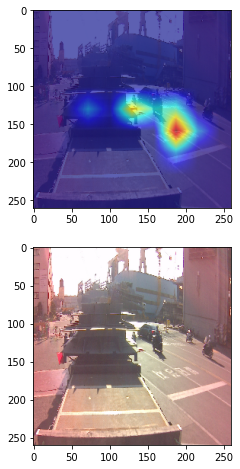

In [ ]:
printcam(images_1[6], 1)

In [ ]:
printcam(images_1[3], 0)

IndexError: ignored

<Figure size 936x576 with 0 Axes>

In [ ]:
name = '/content/drive/Shareddrives/현대제조공정/data/Competition_No1/datasets/test/1/loaded_V1.jpg'

In [ ]:
labels_map = [0, 1]

-----
1                                                                           (51.92%)
0                                                                           (48.08%)


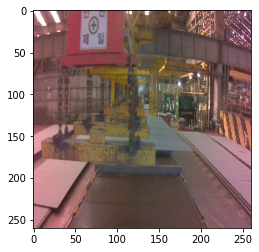

In [ ]:
img = Image.open(images_1[3])
tfms = transforms.Compose([
                              transforms.ToTensor(),
       #transforms.Lambda(lambda x : crop244(x)),
      transforms.Resize((image_size,image_size))])
    #                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(img).unsqueeze(0) 

model.eval()
model.cpu()
logits = model(img.cpu()).to(device)
preds = torch.topk(logits, k=2).indices.squeeze(0).tolist()
img = img.swapaxes(1,2)
img = img.swapaxes(2,3)
plt.imshow(img.cpu().squeeze(0))
print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

-----
0                                                                           (63.72%)
1                                                                           (36.28%)


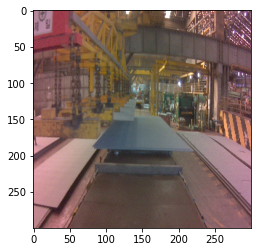

In [ ]:
img = Image.open(images_1[9])
tfms = transforms.Compose([
                              transforms.ToTensor(),
       #transforms.Lambda(lambda x : crop244(x)),
      transforms.Resize((image_size,image_size))])
    #                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(img).unsqueeze(0) 

model.eval()
model.cpu()
logits = model(img.cpu()).to(device)
preds = torch.topk(logits, k=2).indices.squeeze(0).tolist()
img = img.swapaxes(1,2)
img = img.swapaxes(2,3)
plt.imshow(img.cpu().squeeze(0))
print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

-----
1                                                                           (50.59%)
0                                                                           (49.41%)
-----
1                                                                           (50.55%)
0                                                                           (49.45%)
-----
1                                                                           (50.69%)
0                                                                           (49.31%)
-----
1                                                                           (51.92%)
0                                                                           (48.08%)
-----
1                                                                           (50.87%)
0                                                                           (49.13%)
-----
1                                                                           (50.27%)
0                            

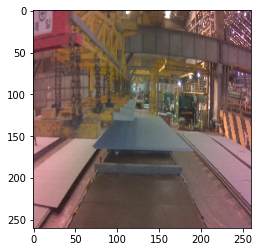

In [ ]:
for i in range(len(images_1)):
  img = Image.open(images_1[i])
  tfms = transforms.Compose([
                              transforms.ToTensor(),
       #transforms.Lambda(lambda x : crop244(x)),
      transforms.Resize((image_size,image_size))])
    #                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
  img = tfms(img).unsqueeze(0) 

  model.eval()
  model.cpu()
  logits = model(img.cpu()).to(device)
  preds = torch.topk(logits, k=2).indices.squeeze(0).tolist()
  img = img.swapaxes(1,2)
  img = img.swapaxes(2,3)
  plt.imshow(img.cpu().squeeze(0))
  print('-----')
  for idx in preds:
      label = labels_map[idx]
      prob = torch.softmax(logits, dim=1)[0, idx].item()
      print('{:<75} ({:.2f}%)'.format(label, prob*100))